In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.graph_objects as go

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv", index_col=0, parse_dates=True)
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


Text(0, 0.5, 'Closing Prices (INR)')

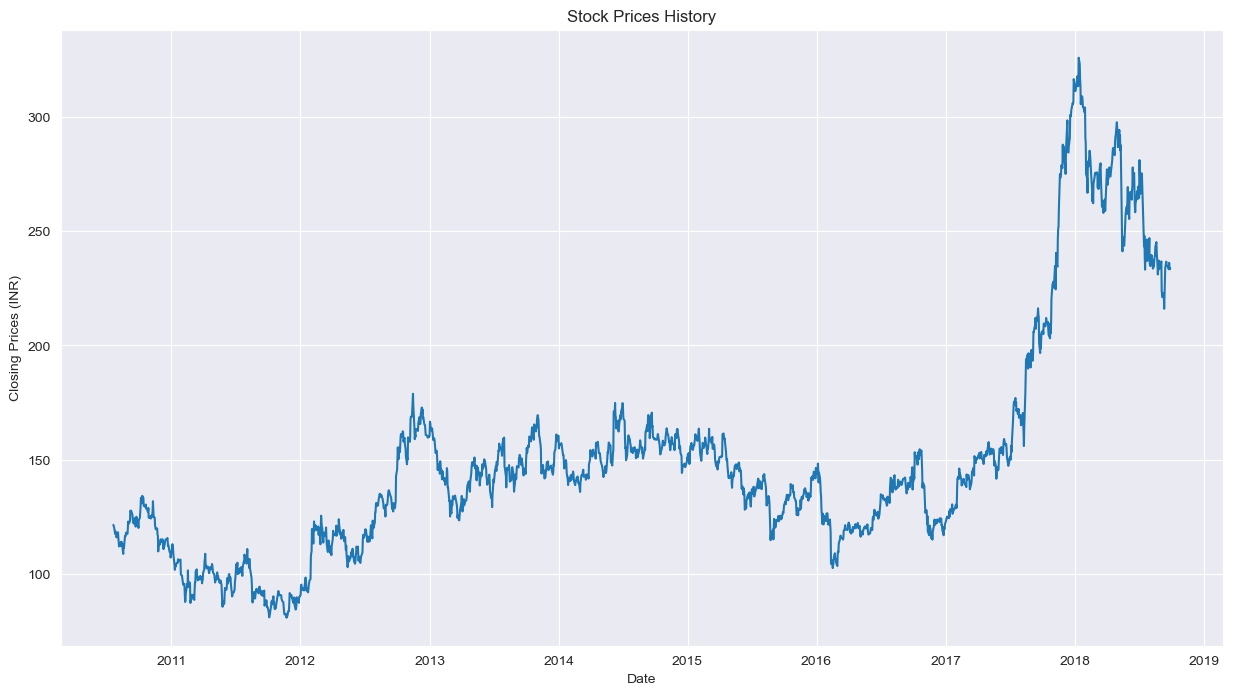

In [7]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Prices (INR)')

In [5]:
correlation = df.corr()
print(correlation["Close"].sort_values(ascending=False))

Close                   1.000000
Last                    0.999961
High                    0.999194
Low                     0.999119
Open                    0.997840
Turnover (Lacs)         0.624213
Total Trade Quantity    0.398911
Name: Close, dtype: float64


In [11]:
close_prices = df['Close'].values
training_data_len = math.ceil(len(close_prices)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

In [12]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = close_prices[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33,201
Trainable params: 33,201
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=100)

Epoch 1/100
49/49 [==============================] - 3s 22ms/step - loss: 0.0105
Epoch 2/100
49/49 [==============================] - 1s 22ms/step - loss: 9.8894e-04
Epoch 3/100
49/49 [==============================] - 1s 21ms/step - loss: 9.7638e-04
Epoch 4/100
49/49 [==============================] - 1s 21ms/step - loss: 0.0010
Epoch 5/100
49/49 [==============================] - 1s 24ms/step - loss: 8.5233e-04
Epoch 6/100
49/49 [==============================] - 1s 21ms/step - loss: 7.9416e-04
Epoch 7/100
49/49 [==============================] - 2s 39ms/step - loss: 8.1900e-04
Epoch 8/100
49/49 [==============================] - 2s 40ms/step - loss: 7.6431e-04
Epoch 9/100
49/49 [==============================] - 2s 41ms/step - loss: 7.0183e-04
Epoch 10/100
49/49 [==============================] - 1s 26ms/step - loss: 6.8011e-04
Epoch 11/100
49/49 [==============================] - 1s 24ms/step - loss: 6.2820e-04
Epoch 12/100
49/49 [==============================] - 1s 21ms/step - lo

In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

13/13 [==============================] - 1s 9ms/step


0.7593230863753933

C:\Users\Raj\AppData\Local\Temp\ipykernel_15020\3001358295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


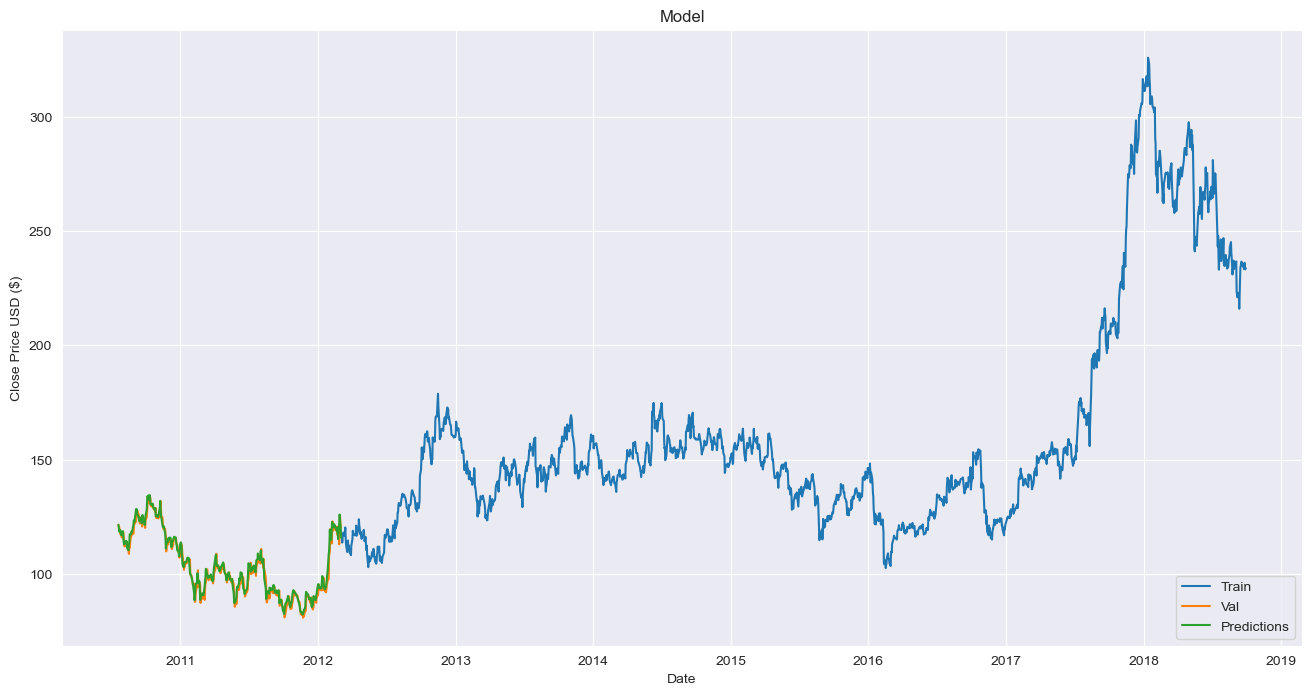

In [23]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()